In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from transformers import LlamaTokenizer, LlamaForCausalLM
import os
import gc
from typing import List, Dict, Any, Optional, Tuple
import json

In [54]:
DEVICE = torch.device('cpu')  # 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_PATH = "meta-llama/Llama-2-7b-chat-hf"
OUTPUT_DIR = "./scraped_data"
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Using device: {DEVICE}")
print(f"Output directory: {OUTPUT_DIR}")

Using device: cpu
Output directory: ./scraped_data


In [55]:
tokenizer = LlamaTokenizer.from_pretrained(MODEL_PATH)
tokenizer.pad_token = tokenizer.eos_token

model = LlamaForCausalLM.from_pretrained(
    MODEL_PATH,
    torch_dtype=torch.float16,
    device_map=DEVICE
)
model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-05)
   

In [19]:
# class ExecutionTracer:
#     def __init__(self):
#         self.execution_order = []
#         self.counter = 0
    
#     def __call__(self, module, input, output):
#         self.counter += 1
#         module_name = None
#         for name, mod in model.named_modules():
#             if mod is module:
#                 module_name = name
#                 break
        
#         self.execution_order.append({
#             'order': self.counter,
#             'name': module_name,
#             'type': module.__class__.__name__,
#             'input_shape': input[0].shape if isinstance(input, tuple) and len(input) > 0 else 'special',
#             'output_shape': output.shape if hasattr(output, 'shape') else type(output).__name__
#         })

# # Create tracer and register hooks
# tracer = ExecutionTracer()
# hooks = []
# for name, module in model.named_modules():
#     # Skip container modules
#     if len(list(module.children())) == 0:
#         hooks.append(module.register_forward_hook(tracer))

# # Run a forward pass
# input_ids = tokenizer("Hello world", return_tensors="pt").input_ids
# with torch.no_grad():
#     output = model(input_ids)

# # Print execution order
# print("LAYER EXECUTION ORDER:")
# print("="*100)
# for item in tracer.execution_order:
#     print(f"{item['order']:3d}. {item['name']:<50} | {item['type']:<20} | {item['input_shape']} → {item['output_shape']}")

# # Clean up hooks
# for hook in hooks:
#     hook.remove()


In [56]:
# Global variables for activation capture
captured_activations = {}
current_hooks = []

def clear_activations():
    global captured_activations
    captured_activations.clear()
    gc.collect()

def remove_all_hooks():
    global current_hooks
    for hook in current_hooks:
        try:
            hook.remove()
        except:
            pass
    current_hooks.clear()

def get_activation_hook(name):
    def hook(module, input, output):
        try:
            if output is None:
                activation = None
            elif isinstance(output, tuple):
                activation = output[0]
            else:
                activation = output
            
            input_tensor = input[0] if isinstance(input, tuple) and len(input) > 0 else None
            
            def safe_detach_cpu(tensor):
                if tensor is None:
                    return None
                try:
                    if hasattr(tensor, 'device') and str(tensor.device) == 'meta':
                        return None
                    return tensor.detach().cpu()
                except:
                    return None
            
            captured_activations[name] = {
                'output': safe_detach_cpu(activation),
                'input': safe_detach_cpu(input_tensor),
            }
        except Exception as e:
            captured_activations[name] = {'output': None, 'input': None}
    return hook

def register_final_norm_hook(model):
    global current_hooks
    remove_all_hooks()
    current_hooks.append(model.model.norm.register_forward_hook(get_activation_hook("final_norm")))

def run_model_and_capture(model, inputs):
    clear_activations()
    register_final_norm_hook(model)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    remove_all_hooks()
    return captured_activations.copy(), outputs

In [57]:
def compute_swap_gradient(
    z: torch.Tensor,
    W: torch.Tensor,
    top1_idx: int,
    top2_idx: int,
    norm_layer: nn.Module,
    bias: Optional[torch.Tensor] = None
) -> torch.Tensor:
    z = z.clone().detach().requires_grad_(True)
    
    # Forward pass through RMSNorm
    z_norm = norm_layer(z)
    
    # Compute logits
    logits = F.linear(z_norm, W, bias)
    
    # Compute probabilities
    probs = F.softmax(logits, dim=-1)
    
    # Swap loss: minimize p[top1] - p[top2]
    swap_loss = probs[top1_idx] - probs[top2_idx]
    
    # Backward pass
    swap_loss.backward()
    
    return -z.grad.detach()


def compute_neuron_scores(
    gradient: torch.Tensor,
    W: torch.Tensor
) -> Tuple[torch.Tensor, torch.Tensor]:
    w_col_norms = torch.norm(W, dim=0)  # [hidden_size]
    projections = gradient * w_col_norms  # [hidden_size]
    scores = torch.abs(projections)
    return scores, projections

In [58]:
def extract_z_values_and_scores(model, tokenizer, input_text: str, input_id: int) -> Dict[str, Any]:
    # Tokenize input
    sample_input = tokenizer(input_text, return_tensors="pt")
    inputs_on_device = {k: v.to(model.device) for k, v in sample_input.items()}
    
    # Run model and capture activations
    activations, outputs = run_model_and_capture(model, inputs_on_device)
    
    # Get pre-norm activations (z values) - input to final_norm
    pre_norm_activations = activations['final_norm']['input']
    if pre_norm_activations is None:
        pre_norm_activations = activations['final_norm']['output']
    pre_norm_activations = pre_norm_activations.float()
    
    # Get z for last token position
    seq_len = pre_norm_activations.shape[1]
    last_token_pos = seq_len - 1
    z = pre_norm_activations[0, last_token_pos, :]  # [hidden_size=4096]
    
    # Get model components
    norm_layer = model.model.norm
    W = model.lm_head.weight.detach().float()  # [vocab_size=32000, hidden_size=4096]
    bias = model.lm_head.bias.detach().float() if hasattr(model.lm_head, 'bias') and model.lm_head.bias is not None else None
    
    # Compute original logits and probabilities
    z_norm = norm_layer(z)
    original_logits = F.linear(z_norm, W, bias)
    original_probs = F.softmax(original_logits, dim=-1)
    
    # Get top-k predictions
    k = 10
    top_logits, top_indices = torch.topk(original_logits, k)
    top_probs = original_probs[top_indices]
    
    top1_idx = top_indices[0].item()
    top2_idx = top_indices[1].item()
    
    # Compute gradient and scores
    gradient = compute_swap_gradient(z, W, top1_idx, top2_idx, norm_layer, bias)
    scores, signed_projections = compute_neuron_scores(gradient, W)
    
    # Find special node (highest impact neuron)
    special_node_idx = torch.argmax(scores).item()
    special_node_score = scores[special_node_idx].item()
    
    # Prepare result
    result = {
        'input_id': input_id,
        'input_text': input_text,
        'seq_len': seq_len,
        'hidden_size': z.shape[0],
        
        # Z values (pre-norm activations)
        'z_values': z.cpu().numpy(),  # [4096]
        
        # Scores and projections
        'scores': scores.cpu().numpy(),  # [4096]
        'signed_projections': signed_projections.cpu().numpy(),  # [4096]
        'gradient': gradient.cpu().numpy(),  # [4096]
        
        # Special node info
        'special_node_idx': special_node_idx,
        'special_node_score': special_node_score,
        
        # Top-k predictions
        'top_k_indices': top_indices.cpu().numpy(),  # [k]
        'top_k_logits': top_logits.detach().cpu().numpy(),  # [k]
        'top_k_probs': top_probs.detach().cpu().numpy(),  # [k]
        'top_k_tokens': [tokenizer.decode([idx]) for idx in top_indices.tolist()],
        
        # Full logits for analysis (optional - can be large)
        'original_logits': original_logits.detach().cpu().numpy(),  # [vocab_size=32000]
    }
    
    # Clean up
    del activations, pre_norm_activations
    clear_activations()
    
    return result

In [59]:
def save_lm_head_weights(model, output_dir: str):
    W = model.lm_head.weight.detach().cpu().float().numpy()
    np.save(os.path.join(output_dir, "lm_head_weights.npy"), W)
    print(f"Saved lm_head weights: shape={W.shape}")
    
    # Save norm layer weight (gamma for RMSNorm)
    norm_weight = model.model.norm.weight.detach().cpu().float().numpy()
    np.save(os.path.join(output_dir, "final_norm_weight.npy"), norm_weight)
    print(f"Saved final_norm weight (gamma): shape={norm_weight.shape}")
    
    # Save bias if it exists
    if hasattr(model.lm_head, 'bias') and model.lm_head.bias is not None:
        bias = model.lm_head.bias.detach().cpu().float().numpy()
        np.save(os.path.join(output_dir, "lm_head_bias.npy"), bias)
        print(f"Saved lm_head bias: shape={bias.shape}")
    
    # Save model config info
    config_info = {
        'hidden_size': model.config.hidden_size,
        'vocab_size': model.config.vocab_size,
        'num_hidden_layers': model.config.num_hidden_layers,
        'rms_norm_eps': model.config.rms_norm_eps,
    }
    with open(os.path.join(output_dir, "model_config.json"), 'w') as f:
        json.dump(config_info, f, indent=2)
    print(f"Saved model config: {config_info}")

In [60]:
def save_input_data(result: Dict[str, Any], output_dir: str):

    input_id = result['input_id']
    input_dir = os.path.join(output_dir, f"input_{input_id}")
    os.makedirs(input_dir, exist_ok=True)
    
    # Save z values
    np.save(os.path.join(input_dir, "z_values.npy"), result['z_values'])
    
    # Save scores and projections
    np.save(os.path.join(input_dir, "scores.npy"), result['scores'])
    np.save(os.path.join(input_dir, "signed_projections.npy"), result['signed_projections'])
    np.save(os.path.join(input_dir, "gradient.npy"), result['gradient'])
    
    # Save top-k predictions
    np.save(os.path.join(input_dir, "top_k_indices.npy"), result['top_k_indices'])
    np.save(os.path.join(input_dir, "top_k_logits.npy"), result['top_k_logits'])
    np.save(os.path.join(input_dir, "top_k_probs.npy"), result['top_k_probs'])
    
    # Save original logits (full vocab)
    np.save(os.path.join(input_dir, "original_logits.npy"), result['original_logits'])
    
    # Save metadata as JSON
    metadata = {
        'input_id': result['input_id'],
        'input_text': result['input_text'],
        'seq_len': result['seq_len'],
        'hidden_size': result['hidden_size'],
        'special_node_idx': result['special_node_idx'],
        'special_node_score': float(result['special_node_score']),
        'top_k_tokens': result['top_k_tokens'],
        'top_k_probs': [float(p) for p in result['top_k_probs']],
    }
    with open(os.path.join(input_dir, "metadata.json"), 'w') as f:
        json.dump(metadata, f, indent=2)
    
    return input_dir

In [140]:
# Sample texts for analysis
sample_texts = [
    [1, "The capital of France is the"],
    [2, "The largest mammal on Earth is the"],
    [3, "The process of photosynthesis occurs in"],
    [4, "The speed of light in a vacuum is"],
    [5, "The chemical symbol for gold is the"],
    [6, "The human body has how many bones"],
    [7, "The Great Wall of China was built to"],
    [8, "Water boils at what temperature"],
    [9, "The smallest unit of matter is"],
    [10, "Shakespeare wrote the play"],
    [11, "The currency of Japan is"],
    [12, "Mount Everest is located in"],
    [13, "The inventor of the telephone was"],
    [14, "DNA stands for"],
    [15, "The largest ocean on Earth is"],
    [16, "The planet closest to the Sun is"],
    [17, "Gravity was discovered by"],
    [18, "The Amazon rainforest is primarily located in"],
    [19, "The freezing point of water is"],
    [20, "The most abundant gas in Earth's atmosphere is"],
    [21, "The Mona Lisa was painted by"],
    [22, "The longest river in the world is"],
    [23, "Photosynthesis converts carbon dioxide and water into"],
    [24, "The study of earthquakes is called"],
    [25, "The first person to walk on the moon was"]
]


In [141]:
# Save lm_head weights and norm weights
save_lm_head_weights(model, OUTPUT_DIR)

Saved lm_head weights: shape=(32000, 4096)
Saved final_norm weight (gamma): shape=(4096,)
Saved model config: {'hidden_size': 4096, 'vocab_size': 32000, 'num_hidden_layers': 32, 'rms_norm_eps': 1e-05}


In [142]:
# Run extraction for all inputs
print("="*80)
print("Z-VALUE AND SCORE EXTRACTION")
print("="*80)

all_results = []
summary_records = []

for idx, (input_id, input_text) in enumerate(sample_texts):
    print(f"\nProcessing {idx+1}/{len(sample_texts)}: Input ID={input_id}")
    print(f"  Text: '{input_text}'")
    
    # Extract z-values and scores
    result = extract_z_values_and_scores(model, tokenizer, input_text, input_id)
    
    # Save to files
    save_path = save_input_data(result, OUTPUT_DIR)
    
    # Print summary
    print(f"  Special node: idx={result['special_node_idx']}, score={result['special_node_score']:.4f}")
    print(f"  Top-1: '{result['top_k_tokens'][0]}' (p={result['top_k_probs'][0]:.4f})")
    print(f"  Top-2: '{result['top_k_tokens'][1]}' (p={result['top_k_probs'][1]:.4f})")
    print(f"  Saved to: {save_path}")
    
    # Collect summary for CSV
    summary_records.append({
        'input_id': input_id,
        'input_text': input_text,
        'special_node_idx': result['special_node_idx'],
        'special_node_score': result['special_node_score'],
        'z_mean': float(np.mean(result['z_values'])),
        'z_std': float(np.std(result['z_values'])),
        'z_min': float(np.min(result['z_values'])),
        'z_max': float(np.max(result['z_values'])),
        'score_mean': float(np.mean(result['scores'])),
        'score_std': float(np.std(result['scores'])),
        'score_max': float(np.max(result['scores'])),
        'top1_token': result['top_k_tokens'][0],
        'top1_prob': float(result['top_k_probs'][0]),
        'top2_token': result['top_k_tokens'][1],
        'top2_prob': float(result['top_k_probs'][1]),
        'top3_token': result['top_k_tokens'][2],
        'top3_prob': float(result['top_k_probs'][2]),
    })
    
    all_results.append(result)

# Save summary CSV
summary_df = pd.DataFrame(summary_records)
summary_df.to_csv(os.path.join(OUTPUT_DIR, "summary.csv"), index=False)
print(f"\n" + "="*80)
print(f"Extraction complete! Summary saved to {os.path.join(OUTPUT_DIR, 'summary.csv')}")
print("="*80)

Z-VALUE AND SCORE EXTRACTION

Processing 1/25: Input ID=1
  Text: 'The capital of France is the'
  Special node: idx=1360, score=0.0496
  Top-1: 'city' (p=0.2802)
  Top-2: 'most' (p=0.0940)
  Saved to: ./scraped_data/input_1

Processing 2/25: Input ID=2
  Text: 'The largest mammal on Earth is the'
  Special node: idx=1839, score=0.0051
  Top-1: 'blue' (p=0.9931)
  Top-2: 'Blue' (p=0.0056)
  Saved to: ./scraped_data/input_2

Processing 3/25: Input ID=3
  Text: 'The process of photosynthesis occurs in'
  Special node: idx=1573, score=0.1018
  Top-1: 'the' (p=0.7385)
  Top-2: 'special' (p=0.0972)
  Saved to: ./scraped_data/input_3

Processing 4/25: Input ID=4
  Text: 'The speed of light in a vacuum is'
  Special node: idx=1839, score=0.7574
  Top-1: 'approximately' (p=0.4901)
  Top-2: '' (p=0.3251)
  Saved to: ./scraped_data/input_4

Processing 5/25: Input ID=5
  Text: 'The chemical symbol for gold is the'
  Special node: idx=1573, score=0.0665
  Top-1: 'Latin' (p=0.2377)
  Top-2: 'symbol

In [143]:
# Display summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
display(summary_df)


SUMMARY STATISTICS


,input_id,input_text,special_node_idx,special_node_score,z_mean,z_std,z_min,z_max,score_mean,score_std,score_max,top1_token,top1_prob,top2_token,top2_prob,top3_token,top3_prob
0,1,The capital of France is the,1360,0.049634,0.027604,2.152361,-13.679688,61.031250,0.006695,0.005135,0.049634,city,0.280165,most,0.094032,City,0.086295
1,2,The largest mammal on Earth is the,1839,0.005054,0.007843,1.506500,-4.691406,5.738281,0.000396,0.000316,0.005054,blue,0.993140,Blue,0.005602,wh,0.000473
2,3,The process of photosynthesis occurs in,1573,0.101778,0.045302,1.596781,-6.320312,7.074219,0.010161,0.007873,0.101778,the,0.738508,special,0.097212,two,0.049857
3,4,The speed of light in a vacuum is,1839,0.757371,0.039324,1.948638,-8.351562,10.031250,0.014695,0.022300,0.757371,approximately,0.490121,,0.325054,a,0.119420
4,5,The chemical symbol for gold is the,1573,0.066543,0.037698,1.709488,-12.062500,12.695312,0.013542,0.010303,0.066543,Latin,0.237728,symbol,0.231045,element,0.104591
5,6,The human body has how many bones,1360,0.034450,-0.013203,1.807928,-13.453125,15.773438,0.003459,0.002779,0.034450,?,0.906257,in,0.034638,\n,0.022375
6,7,The Great Wall of China was built to,1415,0.090388,0.058531,1.943249,-7.703125,23.875000,0.016591,0.012910,0.090388,protect,0.532271,keep,0.365223,prevent,0.022241
7,8,Water boils at what temperature,1360,0.016751,-0.013873,1.711079,-15.875000,16.218750,0.002723,0.002143,0.016751,?,0.929356,and,0.023401,",",0.014163
8,9,The smallest unit of matter is,3556,0.060568,0.022158,1.936282,-13.984375,16.156250,0.010735,0.008099,0.060568,an,0.475661,the,0.295584,a,0.073514
9,10,Shakespeare wrote the play,1360,0.074688,0.032709,2.099957,-15.406250,13.406250,0.006811,0.005233,0.074688,in,0.508770,"""",0.085625,to,0.051917


In [144]:
def rms_norm(x: np.ndarray, weight: np.ndarray, eps: float = 1e-5) -> np.ndarray:
    rms = np.sqrt(np.mean(x ** 2) + eps)
    return (x / rms) * weight

def compute_logits(z: np.ndarray, W: np.ndarray, norm_weight: np.ndarray, 
                          bias: np.ndarray = None, eps: float = 1e-5) -> np.ndarray:
    z_norm = rms_norm(z, norm_weight, eps)
    logits = z_norm @ W.T  # [hidden_size] @ [hidden_size, vocab_size].T = [vocab_size]
    if bias is not None:
        logits = logits + bias
    return logits

def softmax(x: np.ndarray) -> np.ndarray:
    x_max = np.max(x)
    exp_x = np.exp(x - x_max)
    return exp_x / np.sum(exp_x)

In [145]:
def compute_l2_distance(original_logits: torch.Tensor, perturbed_logits: torch.Tensor) -> float:
    # apply softmax to the logits
    original_logits = F.softmax(original_logits, dim=-1)
    perturbed_logits = F.softmax(perturbed_logits, dim=-1)
    # Compute L2 (Euclidean) distance between two logit vectors
    return torch.norm(original_logits - perturbed_logits, p=2).item()

def compute_cosine_distance(original_logits: torch.Tensor, perturbed_logits: torch.Tensor) -> float:
    # Compute cosine distance (1 - cosine_similarity) between two logit vectors
    cos_sim = F.cosine_similarity(original_logits.unsqueeze(0), perturbed_logits.unsqueeze(0))
    return (1 - cos_sim).item()

def compute_kl_divergence(original_logits: torch.Tensor, perturbed_logits: torch.Tensor) -> float:
    # Compute KL divergence: KL(original || perturbed) after softmax
    original_probs = F.softmax(original_logits, dim=-1)
    perturbed_log_probs = F.log_softmax(perturbed_logits, dim=-1)
    # KL(P || Q) = sum(P * log(P/Q)) = sum(P * (log_P - log_Q))
    kl_div = F.kl_div(perturbed_log_probs, original_probs, reduction='sum')
    return kl_div.item()

def compute_js_divergence(original_logits: torch.Tensor, perturbed_logits: torch.Tensor) -> float:
   # Compute Jensen-Shannon divergence: 0.5*KL(P||M) + 0.5*KL(Q||M) where M = 0.5*(P+Q).
    P = F.softmax(original_logits, dim=-1)
    Q = F.softmax(perturbed_logits, dim=-1)
    M = 0.5 * (P + Q)
    
    # KL(P || M)
    kl_pm = F.kl_div(M.log(), P, reduction='sum')
    # KL(Q || M)
    kl_qm = F.kl_div(M.log(), Q, reduction='sum')
    
    js_div = 0.5 * (kl_pm + kl_qm)
    return js_div.item()

def compute_all_distances(original_logits: torch.Tensor, perturbed_logits: torch.Tensor) -> Dict[str, float]:
    # Compute all distance metrics between original and perturbed logits.
    return {
        'l2_distance': compute_l2_distance(original_logits, perturbed_logits),
        'cosine_distance': compute_cosine_distance(original_logits, perturbed_logits),
        'kl_divergence': compute_kl_divergence(original_logits, perturbed_logits),
        'js_divergence': compute_js_divergence(original_logits, perturbed_logits),
    }

In [146]:
def simulate_perturbation(z: np.ndarray, W: np.ndarray, norm_weight: np.ndarray,
                         neuron_indices: List[int], epsilon: float, signs: np.ndarray,
                         eps: float = 1e-5) -> Tuple[np.ndarray, np.ndarray]:
    z_perturbed = z.copy()
    for idx in neuron_indices:
        z_perturbed[idx] += signs[idx] * epsilon
    
    logits = compute_logits(z_perturbed, W, norm_weight, eps=eps)
    probs = softmax(logits)
    
    return logits, probs

In [147]:
# Load saved weights
W_saved = np.load(os.path.join(OUTPUT_DIR, "lm_head_weights.npy"))
norm_weight_saved = np.load(os.path.join(OUTPUT_DIR, "final_norm_weight.npy"))

# Load model config
with open(os.path.join(OUTPUT_DIR, "model_config.json"), 'r') as f:
    config = json.load(f)

In [160]:
test_input_dir = os.path.join(OUTPUT_DIR, "input_1")
z_test = np.load(os.path.join(test_input_dir, "z_values.npy"))
scores_test = np.load(os.path.join(test_input_dir, "scores.npy"))
signed_proj = np.load(os.path.join(test_input_dir, "signed_projections.npy"))
original_logits = np.load(os.path.join(test_input_dir, "original_logits.npy"))

In [167]:
sorted_indices = np.argsort(scores_test)[::-1]
z_test_sorted = z_test[sorted_indices]
signed_proj_sorted = signed_proj[sorted_indices]
scores_test_sorted = scores_test[sorted_indices] 

for i in range(min(11, len(z_test_sorted))):
    print(f"index: {sorted_indices[i]}, z[{i}]: {z_test_sorted[i]:.4f}, score: {scores_test_sorted[i]:.6f}, signed_proj: {signed_proj_sorted[i]:.6f}")

index: 1360, z[0]: -1.6543, score: 0.049634, signed_proj: 0.049634
index: 1927, z[1]: -2.0215, score: 0.044852, signed_proj: -0.044852
index: 2021, z[2]: 0.3633, score: 0.043515, signed_proj: -0.043515
index: 1839, z[3]: -0.2739, score: 0.031885, signed_proj: 0.031885
index: 3168, z[4]: -1.1582, score: 0.029713, signed_proj: -0.029713
index: 2144, z[5]: -6.0352, score: 0.029541, signed_proj: -0.029541
index: 2327, z[6]: 0.2612, score: 0.028677, signed_proj: 0.028677
index: 2084, z[7]: 2.1289, score: 0.027067, signed_proj: 0.027067
index: 148, z[8]: 0.5615, score: 0.026222, signed_proj: -0.026222
index: 2859, z[9]: 0.4541, score: 0.025892, signed_proj: 0.025892
index: 734, z[10]: -1.6182, score: 0.025821, signed_proj: 0.025821


In [168]:
signs = np.sign(signed_proj)
neuron_subset = [sorted_indices[i] for i in range(1,2)]
neuron_subset

[np.int64(1927)]

In [169]:
pert_logits, pert_probs = simulate_perturbation(
        z_test, W_saved, norm_weight_saved, 
        neuron_subset, epsilon=1.0, signs=signs,
        eps=config['rms_norm_eps']
    )

In [170]:
top1_idx_new = np.argmax(pert_logits)
top1_idx_new, pert_probs[top1_idx_new],tokenizer.decode([top1_idx_new])


(np.int64(4272), np.float32(0.27494928), 'city')

In [153]:
#  (np.int64(3681), np.float32(0.89304), 'Paris') Original
#  (np.int64(3681), np.float32(0.88960004), 'Paris') Perturbed z-1  l2_distance': 0.0037430727388709784,
#  (np.int64(3681), np.float32(0.8895704), 'Paris') Perturbed z-2   l2_distance': 0.004195671994239092,
#  (np.int64(3681), np.float32(0.8860088), 'Paris')  perturbet both l2_distance': 0.008028404787182808,
#  (np.int64(3681), np.float32(0.861918), 'Paris')                 'l2_distance': 0.036753375083208084,


In [ ]:
#original
(np.int64(4272), np.float32(0.28016517), 'city')

#perturbed z-1
(np.int64(4272), np.float32(0.27621847), 'city')
{'l2_distance': 0.006021084729582071,
 'cosine_distance': 0.00011718273162841797,
 'kl_divergence': 0.00024564500199630857,
 'js_divergence': 6.19554630247876e-05}

# perturbed z-2
(np.int64(4272), np.float32(0.27494928), 'city')
{'l2_distance': 0.0065802475437521935,
 'cosine_distance': 8.52346420288086e-05,
 'kl_divergence': 0.00022536475444212556,
 'js_divergence': 5.69676049053669e-05}

In [171]:
original_probs = softmax(original_logits)
top1_idx_orig = np.argmax(original_logits)
#print top1_idx_new and the probability and token original
top1_idx_orig, original_probs[top1_idx_orig],tokenizer.decode([top1_idx_orig])

(np.int64(4272), np.float32(0.28016517), 'city')

In [172]:
original_logits_torch = torch.from_numpy(original_logits).float()
pert_logits_torch = torch.from_numpy(pert_logits).float()
compute_all_distances(original_logits_torch, pert_logits_torch)

{'l2_distance': 0.0065802475437521935,
 'cosine_distance': 8.52346420288086e-05,
 'kl_divergence': 0.00022536475444212556,
 'js_divergence': 5.69676049053669e-05}

In [156]:
# =============================================================================
# HELPER FUNCTIONS FOR ANALYSIS
# =============================================================================

def load_input_data(output_dir: str, input_id: int) -> Dict[str, Any]:
    input_dir = os.path.join(output_dir, f"input_{input_id}")
    
    data = {
        'z_values': np.load(os.path.join(input_dir, "z_values.npy")),
        'scores': np.load(os.path.join(input_dir, "scores.npy")),
        'signed_projections': np.load(os.path.join(input_dir, "signed_projections.npy")),
        'gradient': np.load(os.path.join(input_dir, "gradient.npy")),
        'top_k_indices': np.load(os.path.join(input_dir, "top_k_indices.npy")),
        'top_k_logits': np.load(os.path.join(input_dir, "top_k_logits.npy")),
        'top_k_probs': np.load(os.path.join(input_dir, "top_k_probs.npy")),
        'original_logits': np.load(os.path.join(input_dir, "original_logits.npy")),
    }
    
    with open(os.path.join(input_dir, "metadata.json"), 'r') as f:
        data['metadata'] = json.load(f)
    
    return data

def load_model_weights(output_dir: str) -> Dict[str, Any]:
    weights = {
        'W': np.load(os.path.join(output_dir, "lm_head_weights.npy")),
        'norm_weight': np.load(os.path.join(output_dir, "final_norm_weight.npy")),
    }
    
    bias_path = os.path.join(output_dir, "lm_head_bias.npy")
    if os.path.exists(bias_path):
        weights['bias'] = np.load(bias_path)
    else:
        weights['bias'] = None
    
    with open(os.path.join(output_dir, "model_config.json"), 'r') as f:
        weights['config'] = json.load(f)
    
    return weights


In [157]:
# =============================================================================
# EPSILON PERCENTILE IN ACTIVATION CDF
# =============================================================================

from scipy import stats

def compute_epsilon_percentiles(z_values, epsilon_values):
    z_abs = np.abs(z_values)
    percentiles = {}
    for name, eps in epsilon_values.items():
        # values <= eps
        percentiles[name] = stats.percentileofscore(z_abs, eps, kind='weak')
    return percentiles

print("Percentiles in CDF:")
all_z = []
for input_id in range(1,25):
    data = load_input_data(OUTPUT_DIR, input_id)
    z = data['z_values']
    all_z.extend(np.abs(data['z_values']))
    # Epsilon values to check 
    z_abs = np.abs(z)
    epsilon_values = {
        '0.5': 0.5,
        '1.0': 1.0,
        '2.0': 2.0,
        '3.0': 3.0,
        '4.0': 4.0,
        '5.0': 5.0,
        '6.0': 6.0,
        '7.0': 7.0,
        '8.0': 8.0,
        '9.0': 9.0,
        'median(|z|)': np.median(z_abs,),
        'min(|z|)': np.min(z_abs),
        'mean(|z|)': np.mean(z_abs),
        'max(|z|)': np.max(z_abs),
    }
    
    percentiles = compute_epsilon_percentiles(z, epsilon_values)
    
    print(f"\nInput {input_id}: '{data['metadata']['input_text']}'")
    print(f"  |z| stats: min={np.min(z_abs):.4f}, mean={np.mean(z_abs):.4f}, max={np.max(z_abs):.4f} median={np.median(z_abs):.4f}")
    print(f"  Epsilon percentiles:")
    for name, pct in percentiles.items():
        print(f"    {name:12s} -> {pct:5.2f} th percentile")

Percentiles in CDF:

Input 1: 'The capital of France is the'
  |z| stats: min=0.0001, mean=1.5070, max=61.0312 median=1.2485
  Epsilon percentiles:
    0.5          -> 21.24 th percentile
    1.0          -> 41.11 th percentile
    2.0          -> 71.88 th percentile
    3.0          -> 89.72 th percentile
    4.0          -> 96.70 th percentile
    5.0          -> 98.88 th percentile
    6.0          -> 99.41 th percentile
    7.0          -> 99.63 th percentile
    8.0          -> 99.71 th percentile
    9.0          -> 99.78 th percentile
    median(|z|)  -> 50.00 th percentile
    min(|z|)     ->  0.02 th percentile
    mean(|z|)    -> 59.25 th percentile
    max(|z|)     -> 100.00 th percentile

Input 2: 'The largest mammal on Earth is the'
  |z| stats: min=0.0010, mean=1.2072, max=5.7383 median=1.0195
  Epsilon percentiles:
    0.5          -> 25.12 th percentile
    1.0          -> 48.90 th percentile
    2.0          -> 82.13 th percentile
    3.0          -> 95.24 th percentil

In [158]:
import pandas as pd
df =pd.DataFrame(all_z)
df.describe()

,0
count,98304.000000
mean,1.451392
std,1.260933
min,0.000000
25%,0.563477
50%,1.192383
75%,2.042969
max,63.625000


In [159]:
print(f"  |z| stats: min={np.min(all_z):.4f}, mean={np.mean(all_z):.4f}, max={np.max(all_z):.4f}, median={np.median(all_z):.4f}")
percentiles = compute_epsilon_percentiles(all_z, epsilon_values)
for name, pct in percentiles.items():
        print(f"    {name:12s} -> {pct:5.2f} th percentile")

  |z| stats: min=0.0000, mean=1.4514, max=63.6250, median=1.1924
    0.5          -> 22.23 th percentile
    1.0          -> 42.88 th percentile
    2.0          -> 74.07 th percentile
    3.0          -> 90.32 th percentile
    4.0          -> 96.83 th percentile
    5.0          -> 98.87 th percentile
    6.0          -> 99.49 th percentile
    7.0          -> 99.69 th percentile
    8.0          -> 99.78 th percentile
    9.0          -> 99.84 th percentile
    median(|z|)  -> 49.72 th percentile
    min(|z|)     ->  0.06 th percentile
    mean(|z|)    -> 56.44 th percentile
    max(|z|)     -> 99.87 th percentile


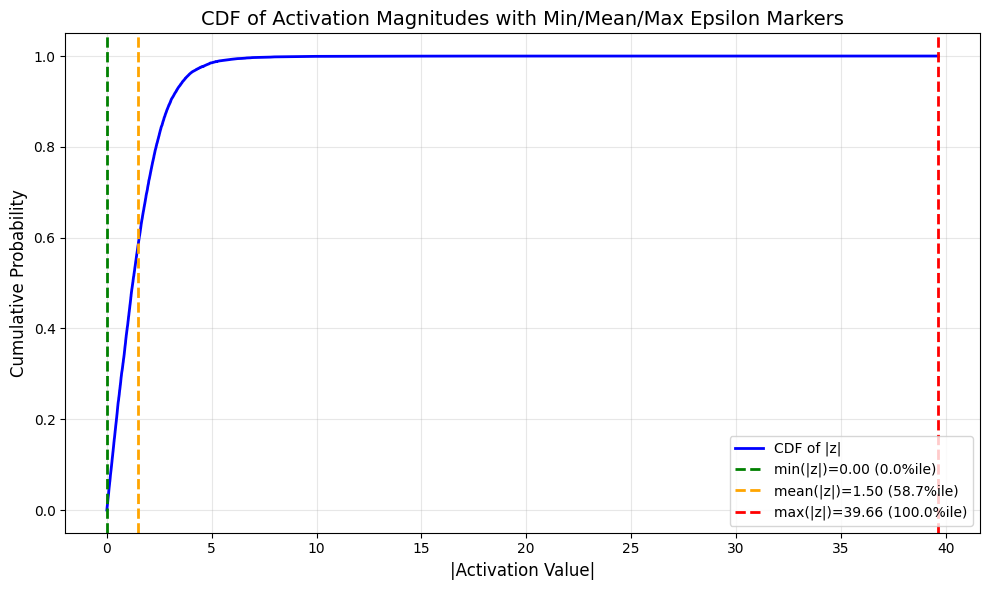

In [ ]:
# =============================================================================
# EPSILON PERCENTILES IN ACTIVATION 
# =============================================================================
import matplotlib.pyplot as plt
from scipy import stats

# Combine z-values from all inputs
all_z = []
for input_id in [1, 2, 3]:
    data = load_input_data(OUTPUT_DIR, input_id)
    all_z.extend(np.abs(data['z_values']))
all_z = np.array(all_z)

# Compute ECDF
sorted_z = np.sort(all_z)
ecdf = np.arange(1, len(sorted_z) + 1) / len(sorted_z)

# Epsilon values to mark
epsilons = {'min': np.min(all_z), 'mean': np.mean(all_z), 'max': np.max(all_z)}

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(sorted_z, ecdf, 'b-', linewidth=2, label='CDF of |z|')

colors = {'min': 'green', 'mean': 'orange', 'max': 'red'}
for name, eps in epsilons.items():
    pct = stats.percentileofscore(all_z, eps, kind='weak')
    ax.axvline(x=eps, color=colors[name], linestyle='--', linewidth=2, 
               label=f'{name}(|z|)={eps:.2f} ({pct:.1f}%ile)')

ax.set_xlabel('|Activation Value|', fontsize=12)
ax.set_ylabel('Cumulative Probability', fontsize=12)
ax.set_title('CDF of Activation Magnitudes with Min/Mean/Max Epsilon Markers', fontsize=14)
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# # =============================================================================
# # Z-VALUE DISTRIBUTION ANALYSIS
# # =============================================================================

# print("\nZ-Value Distribution Analysis:")
# print("="*60)

# for input_id in [1, 2, 3]:
#     data = load_input_data(OUTPUT_DIR, input_id)
#     z = data['z_values']
#     scores = data['scores']
    
#     print(f"\nInput {input_id}: '{data['metadata']['input_text']}'")
#     print(f"  Z-values:  mean={np.mean(z):.4f}, std={np.std(z):.4f}, min={np.min(z):.4f}, max={np.max(z):.4f}")
#     print(f"  Scores:    mean={np.mean(scores):.6f}, std={np.std(scores):.6f}, max={np.max(scores):.6f}")
#     print(f"  Special node: idx={data['metadata']['special_node_idx']}, z={z[data['metadata']['special_node_idx']]:.4f}")
    
#     # Top 5 neurons by score
#     top5_idx = np.argsort(scores)[::-1][:5]
#     print(f"  Top 5 neurons: {list(top5_idx)}")
#     print(f"    Scores: {[f'{scores[i]:.4f}' for i in top5_idx]}")
#     print(f"    Z-values: {[f'{z[i]:.4f}' for i in top5_idx]}")


Z-Value Distribution Analysis:

Input 1: 'The capital of France is'
  Z-values:  mean=0.0553, std=2.2452, min=-12.9531, max=39.6562
  Scores:    mean=0.004006, std=0.003270, max=0.040837
  Special node: idx=3556, z=-2.0195
  Top 5 neurons: [np.int64(3556), np.int64(3241), np.int64(1360), np.int64(1573), np.int64(2084)]
    Scores: ['0.0408', '0.0340', '0.0313', '0.0289', '0.0284']
    Z-values: ['-2.0195', '7.6680', '-7.7617', '-5.3438', '-4.0859']

Input 2: 'The largest mammal on Earth is'
  Z-values:  mean=-0.0251, std=2.0271, min=-17.7500, max=16.8594
  Scores:    mean=0.002380, std=0.001803, max=0.013166
  Special node: idx=2617, z=3.9473
  Top 5 neurons: [np.int64(2617), np.int64(3684), np.int64(1415), np.int64(3518), np.int64(3241)]
    Scores: ['0.0132', '0.0127', '0.0121', '0.0119', '0.0117']
    Z-values: ['3.9473', '-10.6797', '5.1953', '-1.0791', '16.8594']

Input 3: 'The process of photosynthesis occurs in'
  Z-values:  mean=0.0453, std=1.5968, min=-6.3203, max=7.0742
  Sc

In [ ]:
# print("\n" + "="*80)
# print("DATA EXTRACTION COMPLETE!")
# print("="*80)
# print(f"\nOutput directory: {OUTPUT_DIR}")
# print(f"\nSaved files:")
# print(f"  - lm_head_weights.npy: Last layer weights [vocab_size x hidden_size]")
# print(f"  - final_norm_weight.npy: RMSNorm gamma [hidden_size]")
# print(f"  - model_config.json: Model configuration")
# print(f"  - summary.csv: Summary statistics for all inputs")
# print(f"  - input_{{id}}/: Per-input data directories")
# print(f"    - z_values.npy: Pre-norm activations [hidden_size]")
# print(f"    - scores.npy: Neuron impact scores [hidden_size]")
# print(f"    - signed_projections.npy: Signed projections [hidden_size]")
# print(f"    - gradient.npy: Swap gradient [hidden_size]")
# print(f"    - original_logits.npy: Full logits [vocab_size]")
# print(f"    - top_k_*.npy: Top-k predictions")
# print(f"    - metadata.json: Input metadata")
# print("\nYou can now analyze z-values and simulate outputs offline!")